**1) Import Dependencies and mount drive**

In [1]:
# stdlib
import os, re, struct
import glob
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np
from PIL import Image
from tqdm import tqdm

# data & imaging
import pandas as pd
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from PIL import Image
from tqdm.auto import tqdm

# PyTorch
import torch
import torch.nn as nn
from torch.nn.functional import softmax
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# torchvision
import torchvision
from torchvision import transforms

# metrics & plotting
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Colab
#from google.colab import drive

In [2]:
# ─── 1) MOUNT GOOGLE DRIVE ──────────────────────────────────────────────
# drive.mount('/content/drive', force_remount=True)

# ─── 2) DEVICE & CUDNN ──────────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cudnn.benchmark = True  # auto‐tune for fixed input sizes

**2. Train Model**
- We can adjust the following
    - Restricting image size: min and max image width used for training and evaluation
    - Stain type
    - Train and test cases

In [11]:
case_lab = []
for case in labels_df[labels_df['Class'].isin([1,4])]['Case']:
    case_lab.append(class_map[case])
case_df = pd.DataFrame({'Case': labels_df[labels_df['Class'].isin([1,4])]['Case'], 'Class': case_lab})

In [13]:
tr_cases, tst_cases = train_test_split(case_df, train_size = 0.8)
tr_cases = tr_cases['Case'].to_list()
tst_cases = tst_cases['Case'].to_list()

In [25]:
# ─── 1) CONFIG ──────────────────────────────────────────────────────────
image_folder = 'Patches_Apr27'
train_cases  = [2,1,22,9,34,38,53,55,78,62,85,89,21,3,45,49]
test_cases   = [77,60,79,70,90,92,25,12]
train_cases  = [2,1,22,34,53,55,78,62,85,89,21,3,45,49] # Change train cases for ones w/ more patches
test_cases   = [9,38,77,60,79,70,90,92,25,12] # Change test cases for ones w/ more patches
train_cases = tr_cases
test_cases = tst_cases
batch_size   = 64
num_workers  = 0
lr           = 1e-3
num_epochs   = 10
stains       = ['sox10']               # adjust list as needed
min_width    = 4
max_width    = 2048
meta_csv     = 'patch_metadata.csv'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─── 2) LABEL CSV & MAP ─────────────────────────────────────────────────
labels_df = pd.read_csv(
    "case_grade_match.csv"
).drop(index=64, errors='ignore').reset_index(drop=True)
class_map = {int(r.Case): (0 if r.Class == 1 else 1) for _, r in labels_df.iterrows()}

# ─── 3) METADATA BUILD/LOAD ──────────────────────────────────────────────
def build_metadata():
    #if os.path.exists(meta_csv):
        #return pd.read_csv(meta_csv)
    # gather all files
    all_files = [os.path.join(dp, f)
                 for dp, _, fs in os.walk(image_folder)
                 for f in fs if f.lower().endswith('.png')]

    def process(p):
        basename = os.path.basename(p)
        cid_m    = re.search(r'case_(\d+)_', basename, re.IGNORECASE)
        if not cid_m:
            return None
        cid = int(cid_m.group(1))
        # case filter
        if cid not in set(train_cases + test_cases):
            return None
        # stain filter
        name_low = basename.lower()
        stain = next((s for s in stains if s in name_low), None)
        if not stain:
            return None
        # header parse
        try:
            with open(p, 'rb') as f:
                hdr = f.read(24)
            w = struct.unpack('>I', hdr[16:20])[0]
            h = struct.unpack('>I', hdr[20:24])[0]
        except:
            return None
        label = class_map.get(cid)
        return {'path': p, 'case_number': cid, 'stain': stain,
                'width': w, 'height': h, 'label': label}

    with ThreadPoolExecutor(max_workers=8) as exe:
        results = list(exe.map(process, all_files))
    df_meta = pd.DataFrame([r for r in results if r])
    df_meta.to_csv(meta_csv, index=False)
    return df_meta

df_meta = build_metadata()

# ─── 4) FILTER FOR TRAIN/TEST ────────────────────────────────────────────
def filter_meta(df, cases):
    df2 = df[df.case_number.isin(cases)]
    df2 = df2[(df2.width > min_width) & (df2.width < max_width)]
    df2 = df2[df2.stain.isin(stains)]
    return df2

df_train = filter_meta(df_meta, train_cases)
df_test  = filter_meta(df_meta, test_cases)

train_labels = df_train['label'].values
class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts
sample_weights = class_weights[train_labels]
# sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_paths = df_train['path'].tolist()
test_paths  = df_test['path'].tolist()

# ─── 5) TRANSFORMS & DATASETS ─────────────────────────────────────────────
train_transform = transforms.Compose([
    transforms.Resize((224,224)), transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(), transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class CaseDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        try:
            img = Image.open(p).convert('RGB')
        except Exception as e:
            print(f"Failed to load image {p}: {e}")
        # You could raise an error, return a dummy image, or skip
        #img = Image.open(p).convert('RGB')
        if self.transform: img = self.transform(img)
        cid = int(re.search(r'case_(\d+)_', os.path.basename(p), re.IGNORECASE).group(1))
        lbl = class_map[cid]
        return img, lbl

train_ds = CaseDataset(train_paths, transform=train_transform)
test_ds  = CaseDataset(test_paths,  transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True, persistent_workers=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True, persistent_workers=False)

# ─── 6) MODEL SETUP ──────────────────────────────────────────────────────
model = torchvision.models.alexnet(pretrained=True)
for param in model.parameters(): param.requires_grad=False
in_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_ftrs, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=lr)
scaler = torch.cuda.amp.GradScaler()

# ─── 7) TRAIN LOOP ───────────────────────────────────────────────────────
for epoch in range(1, num_epochs+1):
    model.train()
    running = 0.0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{num_epochs}', leave=False)
    for imgs, lbls in pbar:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(): outputs = model(imgs); loss = criterion(outputs, lbls)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        running += loss.item()*lbls.size(0)
        pbar.set_postfix(loss=running/((pbar.n+1)*batch_size))
    print(f'Epoch {epoch}: Train Loss = {running/len(train_ds):.4f}')

# ─── 8) EVALUATION ───────────────────────────────────────────────────────
model.eval(); correct=total=0
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        preds = model(imgs).argmax(1)
        correct += (preds==lbls).sum().item(); total += lbls.size(0)
print(f'Test Accuracy: {100*correct/total:.2f}%') 

C:\Users\akhil\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\akhil\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\akhil\AppData\Local\Temp\ipykernel_17548\2066604481.py:134: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/10:   0%|          | 0/81 [00:00<?, ?it/s]

C:\Users\akhil\AppData\Local\Temp\ipykernel_17548\2066604481.py:144: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): outputs = model(imgs); loss = criterion(outputs, lbls)


Epoch 1: Train Loss = 0.4993


Epoch 2/10:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.4073


Epoch 3/10:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.3862


Epoch 4/10:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.3842


Epoch 5/10:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch 5: Train Loss = 0.3584


Epoch 6/10:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch 6: Train Loss = 0.3785


Epoch 7/10:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch 7: Train Loss = 0.3585


Epoch 8/10:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch 8: Train Loss = 0.3567


Epoch 9/10:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch 9: Train Loss = 0.3537


Epoch 10/10:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch 10: Train Loss = 0.3630
Test Accuracy: 67.02%


In [17]:
def case_level_pred_svc(model, df_train, df_test, train_loader, test_loader, k=25, tune_svc = False, return_pred = False):

    # Collect model predictions for train and test datasets
    model.eval()
    all_probs_tr, all_probs_tst = [], []
    
    for images, labels in train_loader:
        images= (images.to(device, non_blocking=True))
        outputs = model(images)
        probs   = softmax(outputs, dim=1)
        all_probs_tr.extend(probs.detach().cpu().numpy())

    for images, labels in test_loader:
        images = (images.to(device, non_blocking=True))
        outputs = model(images)
        probs   = softmax(outputs, dim=1)
        all_probs_tst.extend(probs.detach().cpu().numpy())
    train_prob = [arr[0] for arr in all_probs_tr]
    test_prob = [arr[0] for arr in all_probs_tst]
    
    # Produce top k predicted probability dataframe for train data
    top_k_prob = pd.DataFrame({'case_number': df_train.case_number.values, 'prob': train_prob}).groupby('case_number', group_keys=False)[['case_number','prob']].apply(lambda x: x.nlargest(k, columns='prob')).reset_index(drop=True)
    top_k_prob['rank'] = top_k_prob.groupby('case_number').cumcount()
    top_k_prob = top_k_prob.pivot(index='case_number', columns='rank', values='prob').dropna()
    case_label = df_train[df_train.case_number.isin(top_k_prob.index)].groupby('case_number')['label'].mean()

    # Make and fit SVC to train predicted probabilities
    if tune_svc:
        pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
        param_grid = [
            {'svc__kernel': ['linear'], 'svc__C': [0.01, 0.1, 1, 10, 100]},
            {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10], 'svc__gamma': ['scale', 0.01, 0.001, 0.0001]}
        ]
        svc = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
        svc.fit(top_k_prob, case_label)
        print('Selected parameters: ' + str(svc.best_params_))
    else:
        svc = make_pipeline(StandardScaler(), LinearSVC())
        svc.fit(top_k_prob, case_label)

    # Produce top k predicted probability dataframe for test data
    top_k_prob_tst = pd.DataFrame({'case_number': df_test.case_number.values, 'prob': test_prob}).groupby('case_number', group_keys=False)[['case_number','prob']].apply(lambda x: x.nlargest(k, columns='prob')).reset_index(drop=True)
    top_k_prob_tst['rank'] = top_k_prob_tst.groupby('case_number').cumcount()
    top_k_prob_tst = top_k_prob_tst.pivot(index='case_number', columns='rank', values='prob').dropna()
    case_label_tst = df_test[df_test.case_number.isin(top_k_prob_tst.index)].groupby('case_number')['label'].mean()

    # Calculate and print train metrics
    train_acc = accuracy_score(case_label, svc.predict(top_k_prob))
    train_rec = recall_score(case_label, svc.predict(top_k_prob))
    train_pre = precision_score(case_label, svc.predict(top_k_prob), zero_division=0)
    print('Train Accuracy: ' + str(train_acc))
    print('Train Recall: ' + str(train_rec))
    print('Train Precision ' + str(train_pre))

    # Calculate and print test metrics
    test_acc = accuracy_score(case_label_tst, svc.predict(top_k_prob_tst))
    test_rec = recall_score(case_label_tst, svc.predict(top_k_prob_tst))
    test_pre = precision_score(case_label_tst, svc.predict(top_k_prob_tst), zero_division=0)
    print('Test Accuracy: ' + str(test_acc))
    print('Test Recall: ' + str(test_rec))
    print('Test Precision ' + str(test_pre))

    # Produce and plot confusion matrix for test data
    cm = confusion_matrix(case_label_tst, svc.predict(top_k_prob_tst))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xticks(ticks=[0,1], labels=['Low-Grade', 'High-Grade'])
    plt.yticks(ticks=[0,1], labels=['Low-Grade', 'High-Grade'])
    plt.xlabel('Predicted Case Grade')
    plt.ylabel('Actual Case Grade')
    plt.show()

    if return_pred:
        return svc.predict(top_k_prob_tst)
    else: 
        return None

In [69]:
def case_level_pred_top_k(model, df_train, df_test, train_loader, test_loader, k=25, return_pred = False):

    # Collect model predictions for train and test datasets
    model.eval()
    all_probs_tr, all_probs_tst = [], []
    
    for images, labels in train_loader:
        images= (images.to(device, non_blocking=True))
        outputs = model(images)
        probs   = softmax(outputs, dim=1)
        all_probs_tr.extend(probs.detach().cpu().numpy())

    for images, labels in test_loader:
        images = (images.to(device, non_blocking=True))
        outputs = model(images)
        probs   = softmax(outputs, dim=1)
        all_probs_tst.extend(probs.detach().cpu().numpy())
    train_prob = [arr[0] for arr in all_probs_tr]
    test_prob = [arr[0] for arr in all_probs_tst]

    # Create train and test dataframes for case-wise average top-k predicted probability
    case_prob_train = pd.concat([pd.DataFrame({'case_number': df_train.case_number.values, 'prob': train_prob}).groupby('case_number')['prob'].apply(lambda x: x.nlargest(25).mean()).reset_index(),df_train.groupby('case_number')['label'].mean().reset_index()], axis=1).iloc[:,[0,1,3]]
    case_prob_tst = pd.concat([pd.DataFrame({'case_number': df_test.case_number.values, 'prob': test_prob}).groupby('case_number')['prob'].apply(lambda x: x.nlargest(25).mean()).reset_index(),df_test.groupby('case_number')['label'].mean().reset_index()], axis=1).iloc[:,[0,1,3]]

    # Produce top k predicted probability dataframe for train data
    # Train decision threshold for k-max probabilities by case
    acc, rec, pre, thresh = [], [], [], []
    for t in np.arange(0.90,1,0.00001):
        acc.append(accuracy_score(case_prob_train.label, (case_prob_train.prob > t).astype(int)))
        rec.append(recall_score(case_prob_train.label, (case_prob_train.prob > t).astype(int)))
        pre.append(precision_score(case_prob_train.label, (case_prob_train.prob > t).astype(int), zero_division=0))
        thresh.append(t)

    print('Tuned Decision Threshold: ' + str(thresh[acc.index(max(acc))]))
    print('Train Accuracy: ' + str(accuracy_score(case_prob_train.label,(case_prob_train.prob > thresh[acc.index(max(acc))]).astype(int))))
    print('Train Recall: ' + str(recall_score(case_prob_train.label,(case_prob_train.prob > thresh[acc.index(max(acc))]).astype(int))))
    print('Train Precision: ' + str(precision_score(case_prob_train.label,(case_prob_train.prob > thresh[acc.index(max(acc))]).astype(int), zero_division=0)))

    print('Test Accuracy: ' + str(accuracy_score(case_prob_tst.label,(case_prob_tst.prob > thresh[acc.index(max(acc))]).astype(int))))
    print('Test Recall: ' + str(recall_score(case_prob_tst.label,(case_prob_tst.prob > thresh[acc.index(max(acc))]).astype(int))))
    print('Test Precision: ' + str(precision_score(case_prob_tst.label,(case_prob_tst.prob > thresh[acc.index(max(acc))]).astype(int), zero_division=0)))

    # Produce and plot confusion matrix for test data
    cm = confusion_matrix(case_prob_tst.label,(case_prob_tst.prob > thresh[acc.index(max(acc))]).astype(int))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xticks(ticks=[0,1], labels=['Low-Grade', 'High-Grade'])
    plt.yticks(ticks=[0,1], labels=['Low-Grade', 'High-Grade'])
    plt.xlabel('Predicted Case Grade')
    plt.ylabel('Actual Case Grade')
    plt.show()

    if return_pred:
        (case_prob_tst.prob > thresh[acc.index(max(acc))]).astype(int)
    else: 
        return None

Train Accuracy: 0.7777777777777778
Train Recall: 0.7647058823529411
Train Precision 0.7647058823529411
Test Accuracy: 0.2222222222222222
Test Recall: 0.5
Test Precision 0.14285714285714285


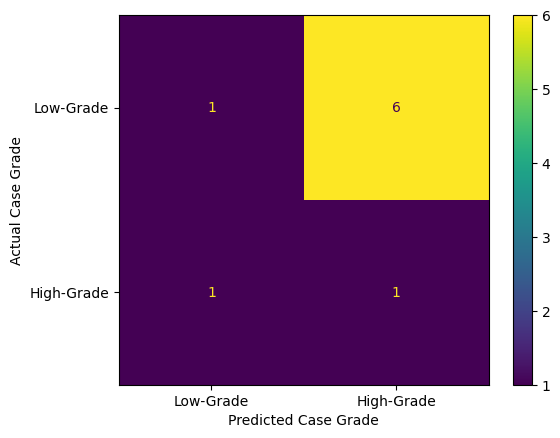

In [425]:
# All stains test, k = 10
case_level_pred_svc(model, df_train, df_test, train_loader, test_loader, 10)

Train Accuracy: 0.6944444444444444
Train Recall: 0.7058823529411765
Train Precision 0.6666666666666666
Test Accuracy: 0.6666666666666666
Test Recall: 0.5
Test Precision 0.3333333333333333


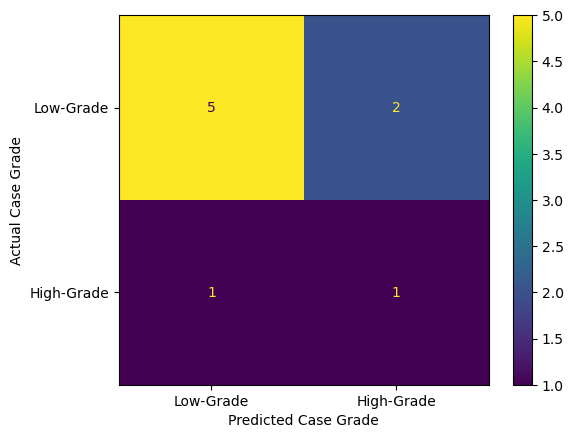

In [426]:
# All stains test, k = 25
case_level_pred_svc(model, df_train, df_test, train_loader, test_loader, 25)

Train Accuracy: 0.75
Train Recall: 0.7058823529411765
Train Precision 0.75
Test Accuracy: 0.5
Test Recall: 0.0
Test Precision 0.0


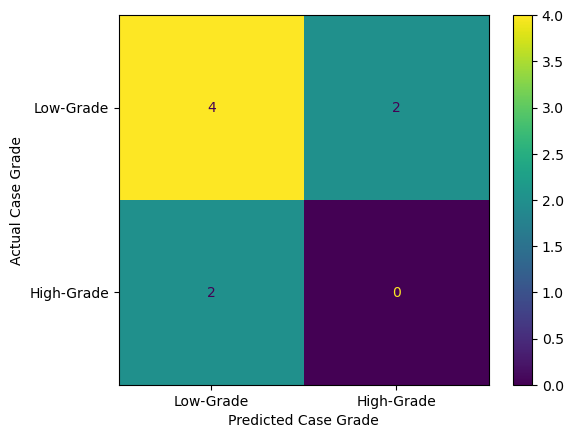

In [427]:
# All stains test, k = 50
case_level_pred_svc(model, df_train, df_test, train_loader, test_loader, 50)

Train Accuracy: 0.6774193548387096
Train Recall: 0.7058823529411765
Train Precision 0.7058823529411765
Test Accuracy: 0.5
Test Recall: 0.5
Test Precision 0.25


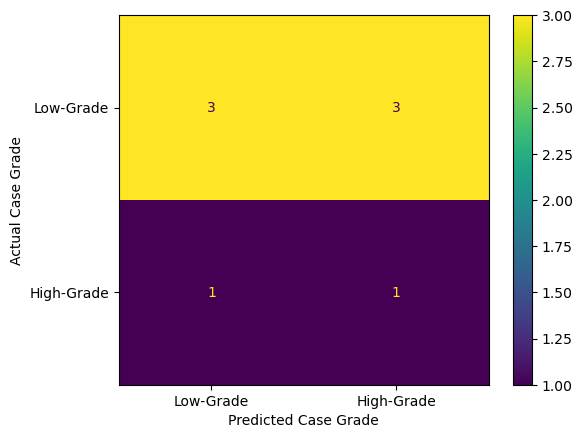

In [408]:
# H&E only test, k = 10
case_level_pred_svc(model, df_train, df_test, train_loader, test_loader, 10)

Train Accuracy: 0.6774193548387096
Train Recall: 0.47058823529411764
Train Precision 0.8888888888888888
Test Accuracy: 0.5
Test Recall: 1.0
Test Precision 0.3333333333333333


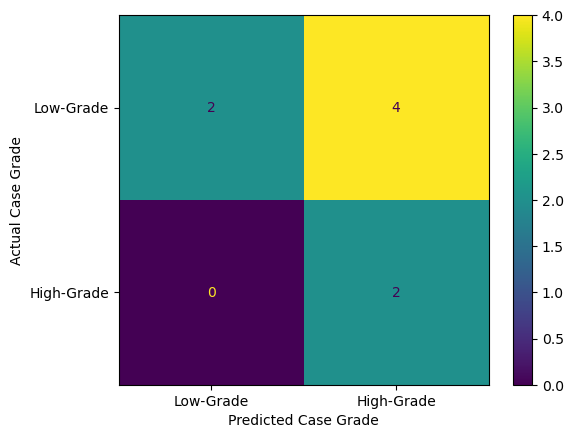

In [410]:
# H&E only test, k = 25
case_level_pred_svc(model, df_train, df_test, train_loader, test_loader, 10)

Train Accuracy: 0.5806451612903226
Train Recall: 0.8823529411764706
Train Precision 0.5769230769230769
Test Accuracy: 0.375
Test Recall: 1.0
Test Precision 0.2857142857142857


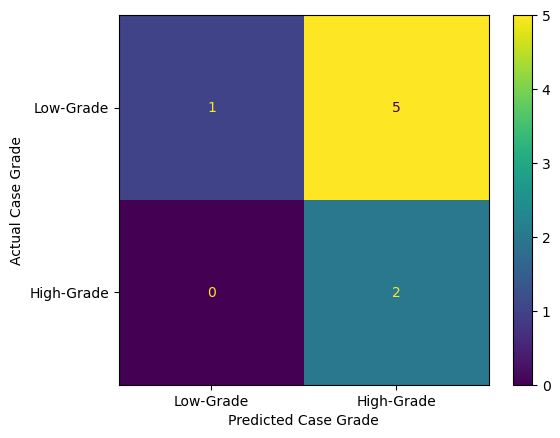

In [412]:
# H&E only test, k = 50
case_level_pred_svc(model, df_train, df_test, train_loader, test_loader, 10)

Train Accuracy: 0.7647058823529411
Train Recall: 0.4666666666666667
Train Precision 1.0
Test Accuracy: 0.5714285714285714
Test Recall: 0.3333333333333333
Test Precision 0.5


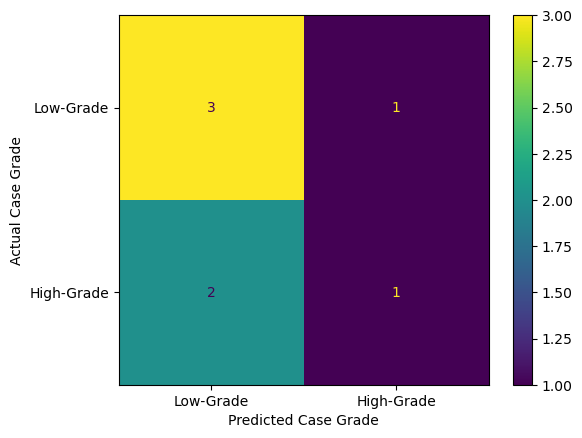

In [396]:
# Melan only test, k = 10
case_level_pred_svc(model, df_train, df_test, train_loader, test_loader, 10)

Train Accuracy: 0.7352941176470589
Train Recall: 0.5333333333333333
Train Precision 0.8
Test Accuracy: 0.7142857142857143
Test Recall: 0.3333333333333333
Test Precision 1.0


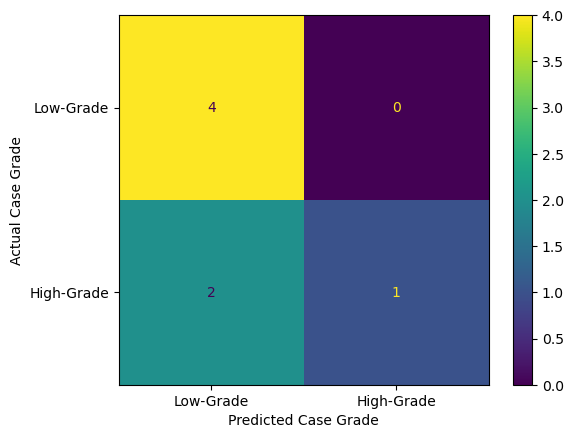

In [394]:
# Melan only test, k = 25
case_level_pred_svc(model, df_train, df_test, train_loader, test_loader, 25)

Train Accuracy: 0.8387096774193549
Train Recall: 0.6666666666666666
Train Precision 0.8888888888888888
Test Accuracy: 0.2857142857142857
Test Recall: 0.6666666666666666
Test Precision 0.3333333333333333


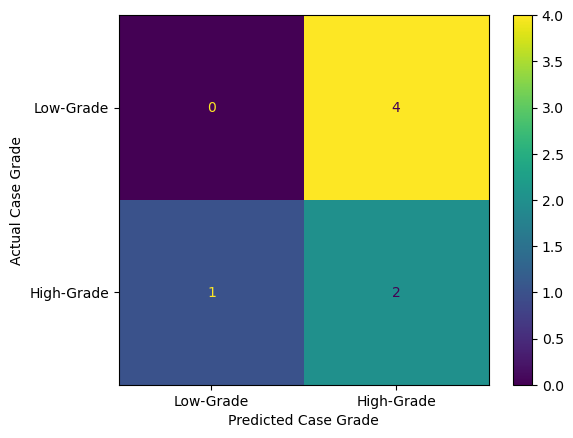

In [404]:
# Melan only test, k = 50
case_level_pred_svc(model, df_train, df_test, train_loader, test_loader, 50)

Train Accuracy: 0.6060606060606061
Train Recall: 0.47058823529411764
Train Precision 0.6666666666666666
Test Accuracy: 0.625
Test Recall: 0.5
Test Precision 0.3333333333333333


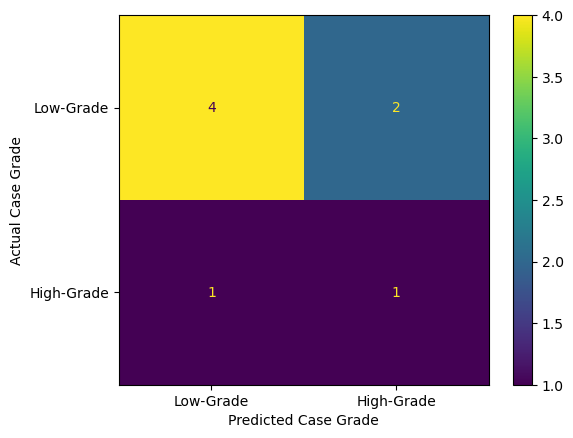

In [416]:
# Sox10 only test, k = 10
case_level_pred_svc(model, df_train, df_test, train_loader, test_loader, 10)

Train Accuracy: 0.696969696969697
Train Recall: 0.4117647058823529
Train Precision 1.0
Test Accuracy: 0.7142857142857143
Test Recall: 0.0
Test Precision 0.0


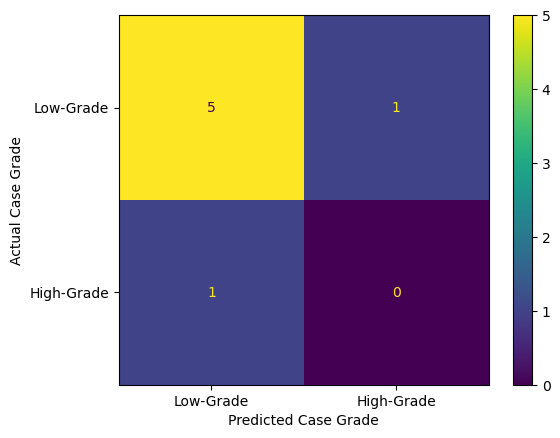

In [418]:
# Sox10 only test, k = 25
case_level_pred_svc(model, df_train, df_test, train_loader, test_loader, 25)

Train Accuracy: 0.8333333333333334
Train Recall: 0.8571428571428571
Train Precision 0.8
Test Accuracy: 0.2857142857142857
Test Recall: 1.0
Test Precision 0.16666666666666666


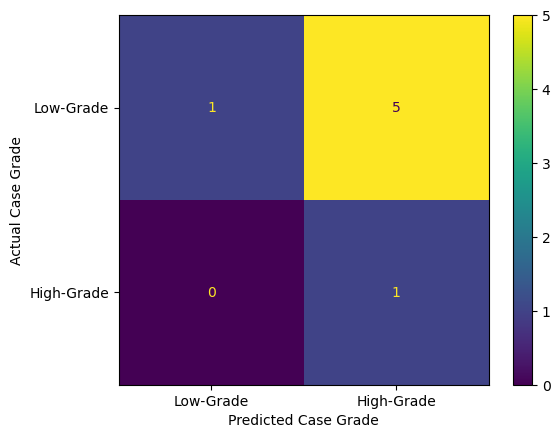

In [419]:
# Sox10 only test, k = 50
case_level_pred_svc(model, df_train, df_test, train_loader, test_loader, 50)

In [439]:
tests = pd.read_csv('decision_method_testing.csv')
tests.head()

,Stain,K,Test Accuracy,Test Recall,Test Precision
0,all,10,0.222,0.5,0.143
1,all,25,0.667,0.5,0.333
2,all,50,0.500,0.0,0.000
3,h&e,10,0.500,0.5,0.250
4,h&e,25,0.500,1.0,0.333


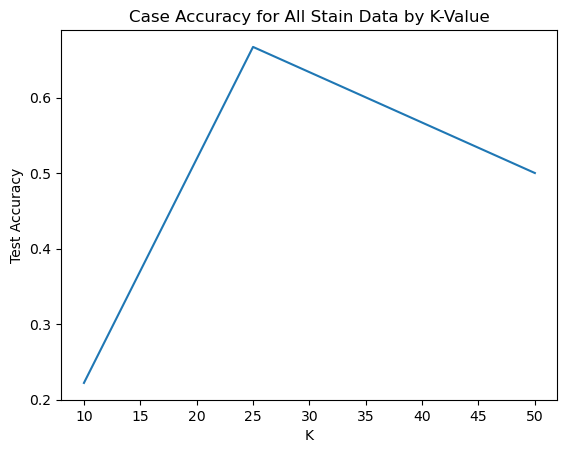

In [503]:
palette = {'all': 'blue', 'h&e': 'red', 'melan': 'orange', 'sox10': 'green'}
sns.lineplot(x = 'K', y = 'Test Accuracy', data = tests[tests['Stain']=='all'])
plt.title('Case Accuracy for All Stain Data by K-Value')
plt.show()

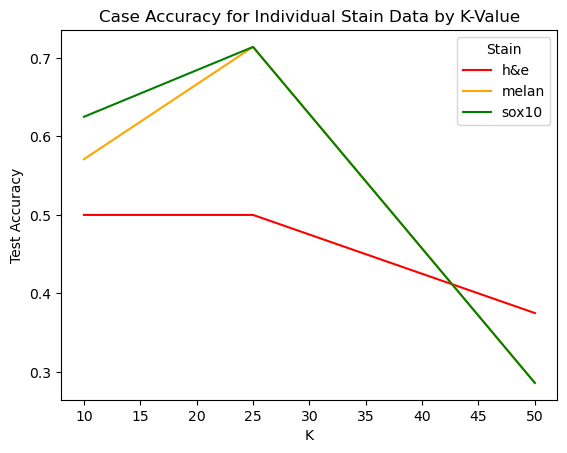

In [497]:
sns.lineplot(x = 'K', y = 'Test Accuracy', data = tests[tests['Stain'].isin(['h&e','melan','sox10'])], hue = 'Stain', palette = palette)
plt.title('Case Accuracy for Individual Stain Data by K-Value')
plt.show()

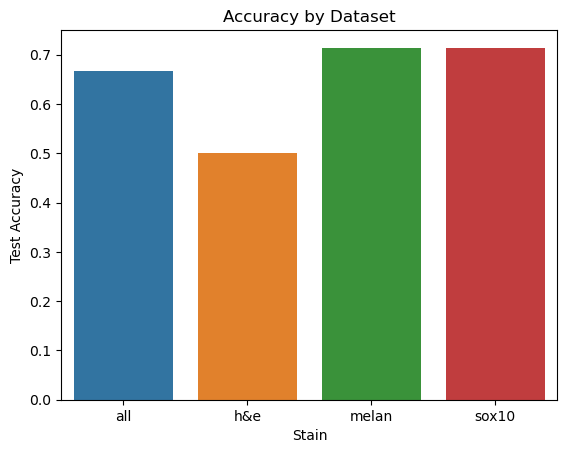

In [505]:
sns.barplot(x = 'Stain', y = 'Test Accuracy', data = tests[tests['K'] == 25], hue = 'Stain')
plt.title('Accuracy by Dataset')
plt.show()

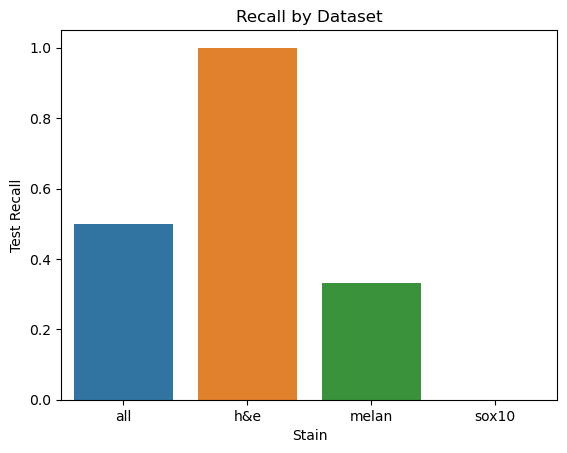

In [507]:
sns.barplot(x = 'Stain', y = 'Test Recall', data = tests[tests['K'] == 25], hue = 'Stain')
plt.title('Recall by Dataset')
plt.show()

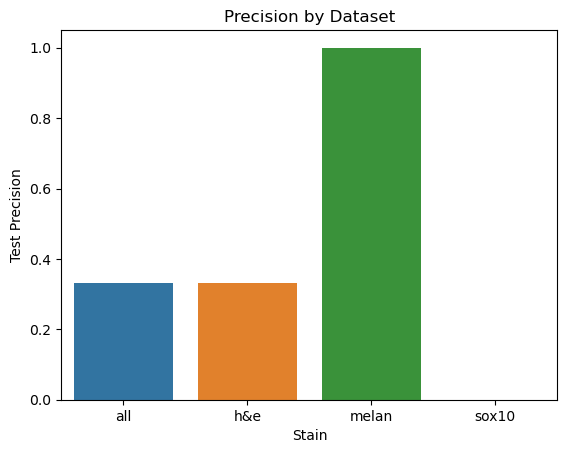

In [511]:
sns.barplot(x = 'Stain', y = 'Test Precision', data = tests[tests['K'] == 25], hue = 'Stain')
plt.title('Precision by Dataset')
plt.show()

Selected parameters: {'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Train Accuracy: 0.5277777777777778
Train Recall: 0.0
Train Precision 0.0
Test Accuracy: 0.7777777777777778
Test Recall: 0.0
Test Precision 0.0


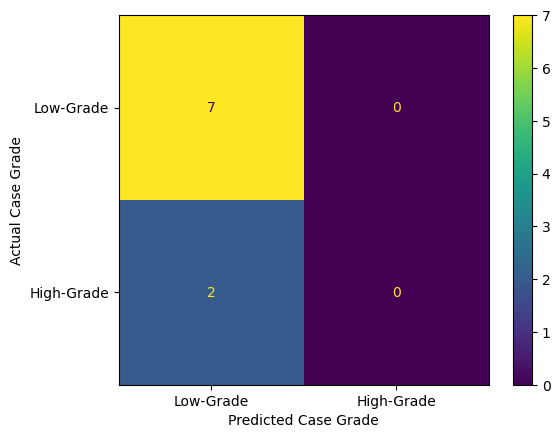

In [547]:
# Tuned SVC all stains
case_level_pred_svc(model, df_train, df_test, train_loader, test_loader, 25, tune_svc=True)

Selected parameters: {'svc__C': 0.01, 'svc__kernel': 'linear'}
Train Accuracy: 0.6129032258064516
Train Recall: 0.14285714285714285
Train Precision 1.0
Test Accuracy: 0.42857142857142855
Test Recall: 0.0
Test Precision 0.0


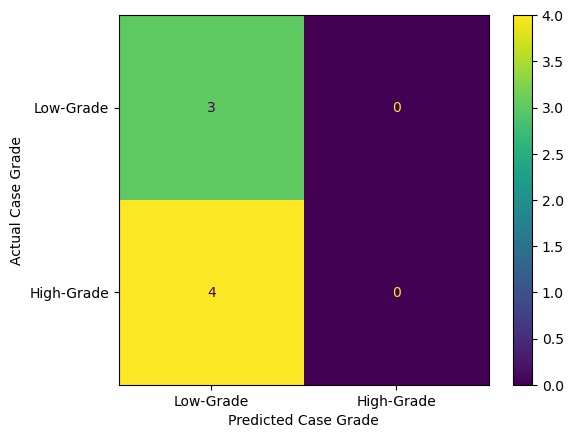

In [19]:
# Tuned SVC h&e
case_level_pred_svc(model, df_train, df_test, train_loader, test_loader, 25, tune_svc=True)

Selected parameters: {'svc__C': 0.01, 'svc__kernel': 'linear'}
Train Accuracy: 0.7058823529411765
Train Recall: 0.35714285714285715
Train Precision 0.8333333333333334
Test Accuracy: 0.7142857142857143
Test Recall: 0.5
Test Precision 1.0


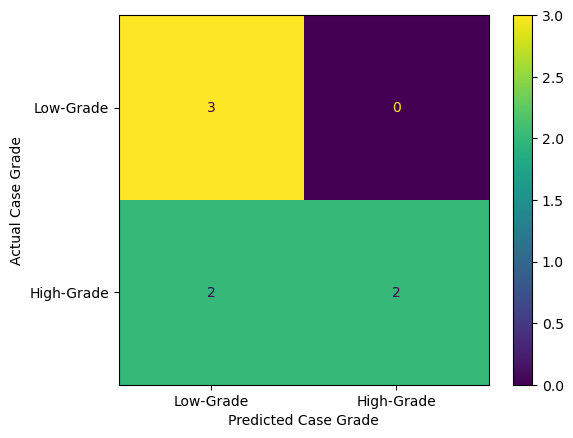

In [23]:
# Tuned SVC melan
case_level_pred_svc(model, df_train, df_test, train_loader, test_loader, 25, tune_svc=True)

Selected parameters: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Train Accuracy: 0.8787878787878788
Train Recall: 0.7142857142857143
Train Precision 1.0
Test Accuracy: 0.5714285714285714
Test Recall: 0.75
Test Precision 0.6


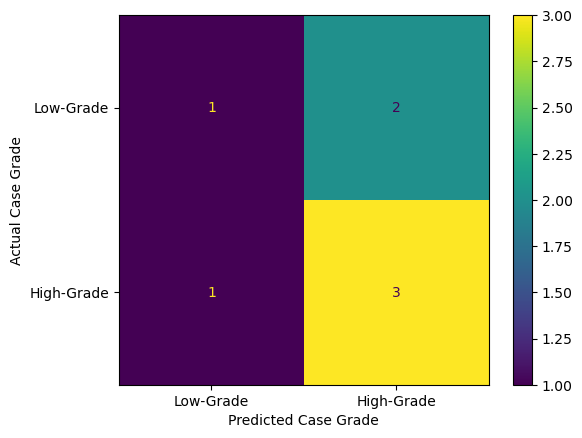

In [27]:
# Tuned SVC sox10
case_level_pred_svc(model, df_train, df_test, train_loader, test_loader, 25, tune_svc=True)